# DAPA Tutorial #2: Area - Sentinel-2

## Load environment variables
Please make sure that the environment variable "DAPA_URL" is set in the `custom.env` file. You can check this by executing the following block. 

If DAPA_URL is not set, please create a text file named `custom.env` in your home directory with the following input: 
>DAPA_URL=YOUR-PERSONAL-DAPA-APP-URL

In [1]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


## Check notebook compabtibility
**Please note:** If you conduct this notebook again at a later time, the base image of this Jupyter Hub service can include newer versions of the libraries installed. Thus, the notebook execution can fail. This compatibility check is only necessary when something is broken. 

In [2]:
from edc import check_compatibility
check_compatibility("user-0.23.2")

## Load libraries
Python libraries used in this tutorial will be loaded.

In [3]:
import os
import xarray as xr
import pandas as pd
import requests
import matplotlib
from ipyleaflet import Map, Rectangle, DrawControl, basemaps, basemap_to_tiles
%matplotlib inline

## Set DAPA endpoint
Execute the following code to check if the DAPA_URL is available in the environment variable and to set the `/dapa` endpoint. 

In [4]:
service_url = None
dapa_url = None

if 'DAPA_URL' not in os.environ:
    print('!! DAPA_URL does not exist as environment variable. Please make sure this is the case - see first block of this notebook! !!')
else:    
    service_url = os.environ['DAPA_URL']
    dapa_url = '{}/{}'.format(service_url, 'oapi')
    print('DAPA path: {}'.format(dapa_url.replace(service_url, '')))

DAPA path: /oapi


## Get collections supported by this endpoint
This request provides a list of collections. The path of each collection is used as starting path of this service.

In [5]:
collections_url = '{}/{}'.format(dapa_url, 'collections')
collections = requests.get(collections_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(collections.url.replace(service_url, '')))
collections.json()

DAPA path: /oapi/collections


['/oapi/collections/DEM/',
 '/oapi/collections/L8L1C/',
 '/oapi/collections/S1GRD/',
 '/oapi/collections/S2L1C/',
 '/oapi/collections/S2L2A/',
 '/oapi/collections/S3OLCI/',
 '/oapi/collections/S3SLSTR/',
 '/oapi/collections/S5PL2/',
 '/oapi/collections/MODIS/']

## Get fields of collection Sentinel-2 L2A
The fields (or variables in other DAPA endpoints - these are the bands of the raster data) can be retrieved in all requests to the DAPA endpoint. In addition to the fixed set of fields, "virtual" fields can be used to conduct math operations (e.g., the calculation of indices). 

In [6]:
collection = 'S2L2A'

fields_url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/fields')
fields = requests.get(fields_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(fields.url.replace(service_url, '')))
fields.json()

DAPA path: /oapi/collections/S2L2A/dapa/fields


[{'id': 'B01', 'wavelength': 442.7},
 {'id': 'B02', 'wavelength': 492.4},
 {'id': 'B03', 'wavelength': 559.8},
 {'id': 'B04', 'wavelength': 664.6},
 {'id': 'B05', 'wavelength': 704.1},
 {'id': 'B06', 'wavelength': 740.5},
 {'id': 'B07', 'wavelength': 782.8},
 {'id': 'B08', 'wavelength': 832.8},
 {'id': 'B8A', 'wavelength': 864.7},
 {'id': 'B09', 'wavelength': 945.1},
 {'id': 'B11', 'wavelength': 1613.7},
 {'id': 'B12', 'wavelength': 2202.4},
 {'id': 'SCL', 'wavelength': None},
 {'id': 'SNW', 'wavelength': None},
 {'id': 'CLD', 'wavelength': None}]

## Retrieve data as raster aggregated by time

### Set DAPA URL and parameters
The output of this request is a single raster (`area` endpoint). As the input collection (S2L2A) is a multi-temporal raster and the output format is an area, temporal aggregation is conducted for each pixel in the area.

To retrieve a single raster, a bounding box (`bbox`) or polygon geometry (`geom`) needs to be provided. The `time` parameter allows to aggregate data only within a specific time span. Also the band (`field`) to be returned by DAPA needs to be specified as well. 

In [7]:
# DAPA URL
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/area')

# Parameters for this request
params = {
    'bbox': '11.49,48.05,11.66,48.22',
    'time': '2018-05-07T10:00:00Z/2018-05-07T12:00:00Z',
    'fields': 'NDVI=(B08-B04)/(B08%2BB04),NDBI=(B11-B08)/(B11%2BB08)', # Please note: + signs need to be URL encoded -> %2B
    'aggregate': 'avg'
}

# show point in the map
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=(48.14, 11.56),
    zoom=10
)

bbox = [float(coord) for coord in params['bbox'].split(',')]
rectangle = Rectangle(bounds=((bbox[1], bbox[0]), (bbox[3], bbox[2])))
m.add_layer(rectangle)

m

Map(center=[48.14, 11.56], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

### Build request URL and conduct request

In [8]:
params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))

DAPA path: /oapi/collections/S2L2A/dapa/area?bbox=11.49,48.05,11.66,48.22&time=2018-05-07T10:00:00Z/2018-05-07T12:00:00Z&fields=NDVI=(B08-B04)/(B08%2BB04),NDBI=(B11-B08)/(B11%2BB08)&aggregate=avg
Status code: 200


### Write raster dataset to GeoTIFF file
The response of the `area` endpoint is currently a GeoTIFF file, which can either be saved to disk or used directly in further processing.

In [9]:
with open('area_avg.tif', 'wb') as filew:
    filew.write(r.content)

### Open raster dataset with xarray
The GeoTIFF file can be opened with xarray. The file consists of bands related to each `field` and each aggregation function (see descriptions attribute in the xarray output). 

In [10]:
ds = xr.open_rasterio('area_avg.tif')
ds

<xarray.DataArray (band: 2, y: 512, x: 512)>
[524288 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2
  * y        (y) float64 48.22 48.22 48.22 48.22 ... 48.05 48.05 48.05 48.05
  * x        (x) float64 11.49 11.49 11.49 11.49 ... 11.66 11.66 11.66 11.66
Attributes:
    transform:               (0.00033203124999999986, 0.0, 11.49, 0.0, -0.000...
    crs:                     +init=epsg:4326
    res:                     (0.00033203124999999986, 0.00033203125000000333)
    is_tiled:                0
    nodatavals:              (nan, nan)
    scales:                  (1.0, 1.0)
    offsets:                 (0.0, 0.0)
    descriptions:            ('NDVI_avg', 'NDBI_avg')
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

### Plot NDVI image (first band)

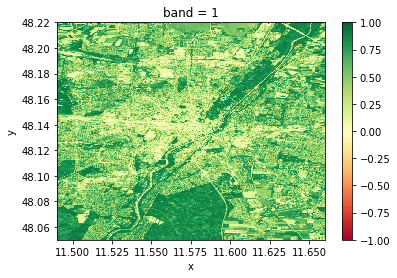

In [11]:
ds[0].plot(cmap="RdYlGn")

## Output gdalinfo

In [12]:
!gdalinfo -stats area_avg.tif

Warning 1: area_avg.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Driver: GTiff/GeoTIFF
Files: area_avg.tif
Size is 512, 512


Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (11.490000000000000,48.219999999999999)
Pixel Size = (0.000332031250000,-0.000332031250000)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_RESOLUTIONUNIT=1 (unitless)
  TIFFTAG_XRESOLUTION=1
  TIFFTAG_YRESOLUTION=1
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=PIXEL
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels 

  Minimum=-1.000, Maximum=1.000, Mean=0.527, StdDev=0.253
  Metadata:
    STATISTICS_MAXIMUM=1
    STATISTICS_MEAN=0.52696186269059
    STATISTICS_MINIMUM=-1
    STATISTICS_STDDEV=0.25294857961659
    STATISTICS_VALID_PERCENT=100
Band 2 Block=512x8 Type=Float32, ColorInterp=Undefined
  Description = NDBI_avg
  Minimum=-0.655, Maximum=1.000, Mean=-0.134, StdDev=0.178
  Metadata:
    STATISTICS_MAXIMUM=1
    STATISTICS_MEAN=-0.13420287323754
    STATISTICS_MINIMUM=-0.65451771020889
    STATISTICS_STDDEV=0.17816229549198
    STATISTICS_VALID_PERCENT=100
